# Dependencies

In [1]:
pacman::p_load(igraph, graphlayouts, ggraph, ggforce, dplyr, ggplot2, GUniFrac)

# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [3]:
gliph_div.fx <- function(datapath, h4hpath, gliph_in_out){
gliph_all <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", gliph_in_out))
gliph_meta <- merge(gliph_all, discovery_metadata, by.x = "subject", by.y = "sample_name")
gliph_meta$disease[ is.na(gliph_meta$disease)] <- "Emerson_unknown"
pat_type <- as.data.frame.matrix(table(gliph_meta %>% select(type, subject)))
return(pat_type)
}

In [4]:
zicoseq.fx <- function(pat_type_matrix, metadata, myvar) {
    # pat_type_matrix is a matrix of GLIPH x samples
    # metadata is a data frame with the metadata for each sample, rownames are the sample names, NA is converted to Unknown for all covariates

    # Match colnames mylist[[1]] and discovery_metadata$sample_name
    metadata_matched <- metadata[colnames(pat_type_matrix), ]

    ZicoSeq.obj <- ZicoSeq(
        meta.dat = metadata_matched, feature.dat = pat_type_matrix,
        grp.name = myvar, adj.name = c("Sex", "study", "Agegroup"), feature.dat.type = "count",
        # Filter to remove rare taxa
        prev.filter = 0, mean.abund.filter = 0,
        max.abund.filter = 0, min.prop = 0,
        # Winsorization to replace outliers
        is.winsor = FALSE, # outlier.pct = 0.03, winsor.end = 'top',
        # Posterior sampling
        is.post.sample = TRUE, post.sample.no = 25,
        # Use the square-root transformation
        link.func = list(function(x) x^0.5), stats.combine.func = max,
        # Permutation-based multiple testing correction
        perm.no = 99, strata = NULL,
        # Reference-based multiple stage normalization
        ref.pct = 0.5, stage.no = 6, excl.pct = 0.2,
        # Family-wise error rate control
        is.fwer = TRUE, verbose = TRUE, return.feature.dat = TRUE
    )

    r2_fdr <- as.data.frame(ZicoSeq.obj$R2)
    r2_fdr$padj <- ZicoSeq.obj$p.adj.fdr[match(rownames(r2_fdr), names(ZicoSeq.obj$p.adj.fdr))]
    return(r2_fdr)
}


# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [6]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [7]:
discovery_metadata <- readr::read_rds(file = paste0(datapath, "discovery_metadata_01.rds"))
discovery_metadata$disease[ is.na(discovery_metadata$disease)] <- "Emerson_unknown"

In [8]:
dim(discovery_metadata)

[1] 973   8

In [9]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds", full.names = FALSE)

In [10]:
filelist

[1] "gliphinput_int_adaptive_sample_01_cluster_gliph_rm_na_singlerm.rds"
 [2] "gliphinput_int_adaptive_sample_02_cluster_gliph_rm_na_singlerm.rds"
 [3] "gliphinput_int_adaptive_sample_03_cluster_gliph_rm_na_singlerm.rds"
 [4] "gliphinput_int_adaptive_sample_04_cluster_gliph_rm_na_singlerm.rds"
 [5] "gliphinput_int_adaptive_sample_05_cluster_gliph_rm_na_singlerm.rds"
 [6] "gliphinput_int_adaptive_sample_06_cluster_gliph_rm_na_singlerm.rds"
 [7] "gliphinput_int_adaptive_sample_07_cluster_gliph_rm_na_singlerm.rds"
 [8] "gliphinput_int_adaptive_sample_08_cluster_gliph_rm_na_singlerm.rds"
 [9] "gliphinput_int_adaptive_sample_09_cluster_gliph_rm_na_singlerm.rds"
[10] "gliphinput_int_adaptive_sample_10_cluster_gliph_rm_na_singlerm.rds"
[11] "gliphinput_int_adaptive_sample_11_cluster_gliph_rm_na_singlerm.rds"
[12] "gliphinput_int_adaptive_sample_12_cluster_gliph_rm_na_singlerm.rds"
[13] "gliphinput_int_adaptive_sample_13_cluster_gliph_rm_na_singlerm.rds"
[14] "gliphinput_int_adaptive_sample_14_cluster_gliph_rm_na_singlerm.rds"
[15] "gliphinput_int_adaptive_sample_15_cluster_gliph_rm_na_singlerm.rds"
[16] "gliphinput_int_adaptive_sample_16_cluster_gliph_rm_na_singlerm.rds"
[17] "gliphinput_int_adaptive_sample_17_cluster_gliph_rm_na_singlerm.rds"
[18] "gliphinput_int_adaptive_sample_18_cluster_gliph_rm_na_singlerm.rds"
[19] "gliphinput_int_adaptive_sample_19_cluster_gliph_rm_na_singlerm.rds"
[20] "gliphinput_int_adaptive_sample_20_cluster_gliph_rm_na_singlerm.rds"

In [18]:
mylist <- lapply(filelist, function(x){ gliph_div.fx(datapath, h4hpath, x )})

In [12]:
#mylist <- lapply(mylist, function(x) as.data.frame(x))

# ZicoSeq

In [20]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [21]:
# make a new variable for the disease
# Group Leukemia, Lymphoma and Solid together as Cancer, all others as Non-Cancer
discovery_metadata$disease_group <- discovery_metadata$disease
discovery_metadata$disease_group[discovery_metadata$disease %in% c("Leukemia", "Lymphoma", "Solid")] <- "Cancer"
discovery_metadata$disease_group[!discovery_metadata$disease %in% c("Leukemia", "Lymphoma", "Solid")] <- "Non-Cancer"

In [22]:
discovery_metadata$Sex[ is.na(discovery_metadata$Sex)] <- "Unknown"
discovery_metadata$Agegroup[ is.na(discovery_metadata$Agegroup)] <- "Unknown"

In [23]:
lapply(mylist, function(x) dim(x))

[[1]]
[1] 281 750

[[2]]
[1] 315 743

[[3]]
[1] 302 756

[[4]]
[1] 285 738

[[5]]
[1] 312 746

[[6]]
[1] 266 732

[[7]]
[1] 292 740

[[8]]
[1] 303 749

[[9]]
[1] 293 764

[[10]]
[1] 277 766

[[11]]
[1] 307 745

[[12]]
[1] 289 742

[[13]]
[1] 303 772

[[14]]
[1] 309 785

[[15]]
[1] 331 773

[[16]]
[1] 296 776

[[17]]
[1] 294 768

[[18]]
[1] 297 744

[[19]]
[1] 275 746

[[20]]
[1] 295 744

In [25]:
# get number of zero for each row in each matrix
mylist_5 <- lapply(mylist, \(x) { x[rowSums(x != 0) > 5  , ] })
mylist_5 <- lapply(mylist_5, \(x) { x[ ,colSums(x != 0) > 1   ] })


In [26]:
zicolist  <- lapply(mylist_5, \(x) {zicoseq.fx(as.matrix(x), discovery_metadata, "disease_group")} )

0  features are filtered!
The data has  580  samples and  185  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  584  samples and  207  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  605  samples and  191  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  602  samples and  199  features will be tested!
Fitting beta mixture ...
Finding the references ...
Permutation testing ...
.........
.........
.........
.........
.........
.........
Completed!
0  features are filtered!
The data has  594  samples and  22

In [27]:
length(zicolist)

[1] 20

In [28]:
dfColList <- lapply(zicolist ,rownames)
commonCols <- Reduce(intersect,dfColList)

In [29]:
commonCols

[1] "global-S%GGE" "global-S%YE"  "global-SL%GE"

In [30]:
zicolist <- lapply(zicolist ,\(x) x[  order(x$padj, decreasing = F),])

In [31]:
lapply(zicolist , head)

,Func1,padj
,<dbl>,<dbl>
global-S%RGET,0.04224600,0.1212121
global-S%PNQP,0.02774736,0.1245791
global-S%RNTE,0.02288730,0.1245791
global-S%SSGANV,0.02628520,0.1245791
global-SL%ENTE,0.02250589,0.1245791
global-SLD%SYE,0.02277487,0.1245791
,Func1,padj
,<dbl>,<dbl>
global-SSG%EET,0.03468535,0.2828283


# PID

In [64]:
library(Biostrings)

In [67]:
data(BLOSUM62)

In [65]:
onetest <- zicolist[[1]]

In [66]:
mygroups <- gsub(".*-", "",rownames(onetest) )

mygroups <- gsub("%", "X",mygroups )

In [77]:
mymat <- matrix(0, nrow = length(mygroups), ncol = length(mygroups),
                dimnames = list(mygroups, mygroups))

In [85]:
mymat <- mymat[1:10,1:10]

In [86]:
mymat

,SXRGET,SXPNQP,SXRNTE,SXSSGANV,SLXENTE,SLDXSYE,SLTGXE,SPRXTGE,SXADT,SXGGTGE
SXRGET,0,0,0,0,0,0,0,0,0,0
SXPNQP,0,0,0,0,0,0,0,0,0,0
SXRNTE,0,0,0,0,0,0,0,0,0,0
SXSSGANV,0,0,0,0,0,0,0,0,0,0
SLXENTE,0,0,0,0,0,0,0,0,0,0
SLDXSYE,0,0,0,0,0,0,0,0,0,0
SLTGXE,0,0,0,0,0,0,0,0,0,0
SPRXTGE,0,0,0,0,0,0,0,0,0,0
SXADT,0,0,0,0,0,0,0,0,0,0
SXGGTGE,0,0,0,0,0,0,0,0,0,0


In [89]:
alm <- pairwiseAlignment(mygroups[1:20],mygroups[1:20], substitutionMatrix=BLOSUM62, gapOpening=0, gapExtension=-5)

In [98]:
D <- combn(10,2)

In [116]:
D

1,1,1,1,1,1,1,1,1,2,...,6,6,6,6,7,7,7,8,8,9
2,3,4,5,6,7,8,9,10,3,...,7,8,9,10,8,9,10,9,10,10


In [124]:
for(i in 1:ncol(D)) {
   aln <- pairwiseAlignment(
   rownames(mymat)[D[1,i]], 
   rownames(mymat)[D[2,i]],  
   substitutionMatrix=BLOSUM62, gapOpening=0, gapExtension=-5)
   mymat[D[1,i],D[2,i]] <- score(aln)
   mymat[D[2,i],D[1,i]] <- score(aln)
}

In [126]:
aln

Global PairwiseAlignmentsSingleSubject (1 of 1)
pattern: SXADT--
subject: SXGGTGE
score: -3 

In [130]:
2/7

[1] 0.2857143

In [127]:
pid(aln)

[1] 60

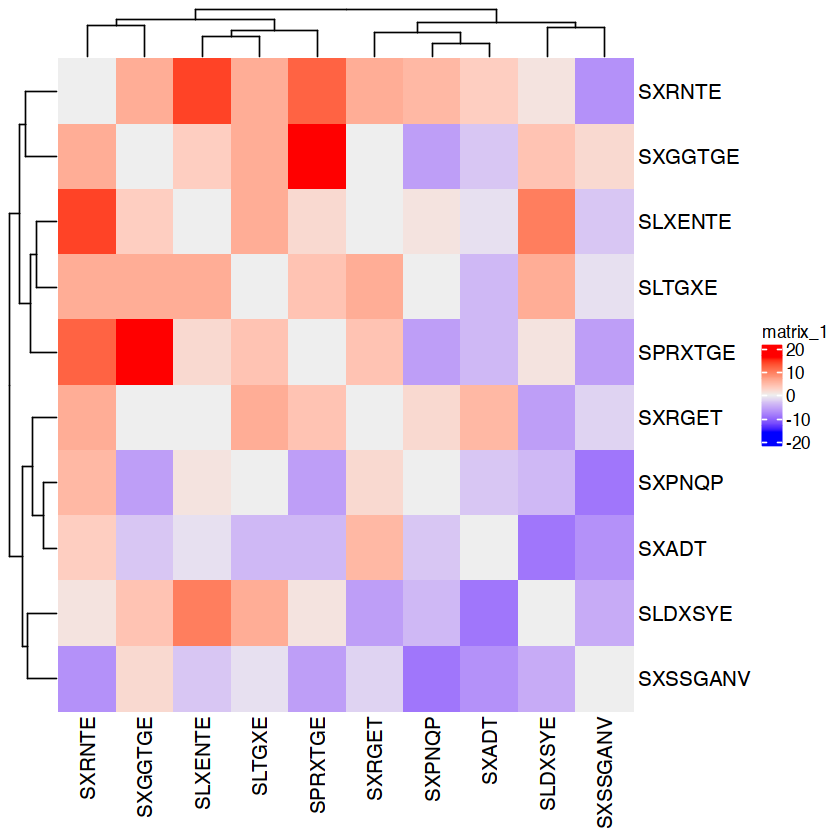

In [136]:
ComplexHeatmap::Heatmap(mymat)

In [100]:
seqs <- c("protein1" =
"MYRALRLLARSRPLVRAPAAALASAPGLGGAAVPSFWPPNAAR
MASQNSFRIEYDTFGELKVPNDKYYGAQTVRSTMNFKIGGVTE
RMPTPVIKAFGILKRAAAEVNQDYGLDPKIANAIMKAADEVAE
GKLNDHFPLVVWQTGSGTQTNMNVNEVISNRAIEMLGGELGSK
IPVHPNDHVNKSQ",
"protein2" =
"MRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDSRP
LPAWFDEAKFGVFIHWGVFSVPAWGSEWFWWHWQGEGRPYQRF
MRDNYPPGFSYADFGPQFTARFFHPEEWADLFQAAGAKYVVLT
TKHHEGFTNW*")

In [103]:
A <- AAStringSet(seqs) #Reading all fasta files at once {biostrings}
A1 <- names(A) # Setting vector to hold all the names from the fasta 
# files retrievd in vector A
A2 <- paste(A) # Setting a vector A2 with pasted values from vector A
ProtDF <- data.frame(A1,A2) 

In [107]:
ProtDF

A1,A2
<chr>,<chr>
protein1,MYRALRLLARSRPLVRAPAAALASAPGLGGAAVPSFWPPNAAR MASQNSFRIEYDTFGELKVPNDKYYGAQTVRSTMNFKIGGVTE RMPTPVIKAFGILKRAAAEVNQDYGLDPKIANAIMKAADEVAE GKLNDHFPLVVWQTGSGTQTNMNVNEVISNRAIEMLGGELGSK IPVHPNDHVNKSQ
protein2,MRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDSRP LPAWFDEAKFGVFIHWGVFSVPAWGSEWFWWHWQGEGRPYQRF MRDNYPPGFSYADFGPQFTARFFHPEEWADLFQAAGAKYVVLT TKHHEGFTNW*


In [112]:
ProtDF[D[2,1],2]

[1] "MRSRPAGPALLLLLLFLGAAESVRRAQPPRRYTPDWPSLDSRP\nLPAWFDEAKFGVFIHWGVFSVPAWGSEWFWWHWQGEGRPYQRF\nMRDNYPPGFSYADFGPQFTARFFHPEEWADLFQAAGAKYVVLT\nTKHHEGFTNW*"

In [111]:
D[2,1]

[1] 2

In [84]:
alm@pattern

[1] SXRGE--T 

In [79]:
mygroups

[1] "SXRGET"    "SXPNQP"    "SXRNTE"    "SXSSGANV"  "SLXENTE"   "SLDXSYE"  
  [7] "SLTGXE"    "SPRXTGE"   "SXADT"     "SXGGTGE"   "SXGPV"     "SDSSXE"   
 [13] "SEGXE"     "SLXGNYG"   "SLXSGE"    "SLXYE"     "SLDRGX"    "SLGGXGE"  
 [19] "SLGGXQP"   "SPXGSYNSP" "XTSGVSYNE" "RGXSE"     "RGTXGTE"   "SXGGYE"   
 [25] "SXSGGNQP"  "SDXDTGE"   "SEXGAGE"   "SEAGX"     "SFXGE"     "SGQGNX"   
 [31] "SLXGE"     "SLXGGE"    "SLXGNQP"   "SLGGXYG"   "SLGQX"     "SLRGXYE"  
 [37] "AVWQ"      "FKQK"      "PDWY"      "KXKTAYE"   "SXGGGSNQP" "SXGPNQP"  
 [43] "SXGTE"     "SXGYE"     "SXSGRATGE" "SLGXE"     "SLGQXGTE"  "SRXVNEK"  
 [49] "SVLAGGGXE" "RAQH"      "SXLGGG"    "SDXNE"     "SLTGXYG"   "KALL"     
 [55] "SRLXNTE"   "SXLGGE"    "SLRDXE"    "SXRGNT"    "SFLXGE"    "YX"       
 [61] "SXMNTE"    "SXTQNTE"   "SDSXGSTDT" "SXGP"      "SXRGYG"    "SLRXE"    
 [67] "SVDRXE"    "RGTGGXE"   "SEXGE"     "SQQGXTE"   "SLXNTE"    "SLGGXE"   
 [73] "SPXAGE"    "SQGGXE"    "SSXGYE"    "FPLV"      "SLXNYG"    "SXGVSGNT" 
 [79] "SLXGNE"    "SLDRXE"    "SSX"       "KQKTAYX"   "SXGGTE"    "SLXGYE"   
 [85] "SLVXGE"    "SXP"       "SDSXE"     "SFGXSYE"   "SLXGDSNQP" "SLXPDT"   
 [91] "SLVGXG"    "SXGLAGAYE" "SXTGGNTE"  "XGRDYE"    "SX"        "SXGAGE"   
 [97] "SLXGGGE"   "SLAGSGX"   "SPPXGTE"   "SQVXTGE"   "SLXGSE"    "SXNTE"    
[103] "SXTGGYG"   "SLXRG"     "SLQGXTE"   "SPGXAGGYE" "SGXSSYNE"  "SXYE"     
[109] "SLVGX"     "WVYE"      "SXE"       "SFXNTE"    "SXGPNTE"   "SLXGDT"   
[115] "SLXGQP"    "SLRGXE"    "SLVXE"     "SVXRDE"    "SYXGE"     "SPGXG"    
[121] "SLGDSX"    "SXQGNTE"   "SXSNQP"    "SQQGXYG"   "SLGGGX"    "RXSYSNQP" 
[127] "SXSSYE"    "XSTDT"     "XYTE"      "SXDDQP"    "SXGGE"     "SXRDSNQP" 
[133] "SXRGGE"    "SXRTGE"    "SGXYE"     "SLGQGXEK"  "SPGTGGX"   "KQKT"     
[139] "SXVG"      "SLEXE"     "SLXGDE"    "SLAGXE"    "SVSGXT"    "SXRDE"    
[145] "SFGXGE"    "SLRGXGE"   "XYE"       "SXGQNTE"   "SXSSGNT"   "SXAGE"    
[151] "SXGSTDT"   "SSGXYE"    "SXGQG"     "SLXRE"     "SXGQET"    "SFXGGNYG" 
[157] "GGTX"      "SLGXG"     "SEGRX"     "SFSXTE"    "SLXQGYE"   "SQGXGET"  
[163] "SXTGE"     "SXQGTGE"   "PYX"       "SLGXGE"    "SXVGE"     "GXG"      
[169] "SLXNQP"    "SXGRE"     "SXGTGGE"   "SLXRNTE"   "SPGXGT"    "SXDRGNQP" 
[175] "SGTGXDYG"  "SVXGE"     "SLDXSE"    "SXGDT"     "SLXGT"     "SQXVGE"   
[181] "SSGQGX"    "SLVSXQP"   "SPGQGXGG"  "XGQGDTGE"  "SXTGGTNEK"

In [ ]:
volcano.fx <- function(resdf, fc, padj, ttl){
    
    # remove padj = NA
    
    resdf <- resdf[ !is.na(resdf$padj),]
    
    resdf$threshold <- NA
    resdf$threshold[ resdf$log2FoldChange > fc & resdf$padj < padj] <- "Up-regulated"
    resdf$threshold[ resdf$log2FoldChange < -fc & resdf$padj < padj] <- "Down-regulated"
    resdf$threshold[ is.na(resdf$threshold)] <- "not significant"
    
res_upreg <- resdf[ resdf$threshold == "Up-regulated",]    
res_upreg <- res_upreg[order(res_upreg$log2FoldChange, decreasing = T),]    
res_downreg <- resdf[ resdf$threshold == "Down-regulated",]    
res_downreg <- res_downreg[order(res_downreg$log2FoldChange, decreasing = F),]  

if(nrow(res_upreg) < 10){
    resdf$genelabels[ rownames(resdf) %in% rownames(res_upreg)] <- "UP"}
if(nrow(res_downreg) < 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_downreg)] <- "DOWN"}    

if(nrow(res_upreg) >= 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_upreg)[1:10]] <- "UP"   }
if(nrow(res_downreg) >= 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_downreg)[1:10]] <- "DOWN" } 
    
    p <- ggplot(resdf, aes(x=log2FoldChange, y=-log10(pvalue))) +
    geom_point(aes(color = threshold), size=2.5) +
    scale_colour_manual(values = c("Down-regulated"= "blue", "Up-regulated"="red",  "not significant"= "black")) +    
    geom_text_repel(data = subset(resdf, genelabels == "UP"),
                    label = subset(resdf, genelabels == "UP")$Gene_gencode,
                    size = 8, box.padding = 1, max.overlaps = Inf,  min.segment.length = 0,
                    direction = "both", nudge_x = 3, nudge_y = 0.5, vjust = 0.5, hjust = 0.5) + 
    geom_text_repel(data = subset(resdf, genelabels == "DOWN"),
                    label = subset(resdf, genelabels == "DOWN")$Gene_gencode,
                    size = 8, box.padding = 1, max.overlaps = Inf, direction = "both", 
                    nudge_x = -3, nudge_y = 0.5,
                    vjust = 0.5, hjust = 0.5, min.segment.length = 0) + 
    myplot + myaxis +
    theme(axis.text.x = element_text(size = 30, angle = 0, hjust = 0.5),
          axis.title = element_text(size = 30), axis.text.y = element_text(size = 30),
          plot.title = element_text(size = 30, hjust = 0.5), legend.position = "none") + 
    labs(x = "Fold change (Log2)" ,y = "p-value (-Log10)", title = ttl)     
    
    return(p)
}